# Full waveform inversion

In the next two lectures we apply some of the methods you have learned in the course thus far to the seismic imaging problem of *Full waveform inversion* (FWI).

The material is intended to
- Give an overview of work flow involved in FWI
- Give an appreciation of the mathematical and numerical techniques
- Introduce you to software that can be used within industrial scale inversion problems

It's not intended to
- Be a deep dive into FWI (whilst we'll outline and even derive some of the more basic mathematics, we'll mainly assume that this then generalises to more complex scenarios)
- Make you FWI experts (there are many 'tricks' that are required in practice - we'll mention, but not study, some of them).

Today we will:
- Put the problem in context
- Learn about Devito (a numerical package we'll use to perform FWI)
- Study the forward modelling aspect of FWI and build an FWI ready wave-propagator

Next week we will:
- Build a basic FWI framework and solve a transmission problem

For the numerical aspects (the coding related aspects of these lectures are not examinable) we'll use `Python` and in particular **Devito**. Some useful Devito links along with installation instructions (for those who would like to install and play around with Devito locally) are posted below:
- Website: https://www.devitoproject.org/
- Github page: https://github.com/devitocodes/devito
- Installation instructions (Unix): https://www.devitoproject.org/devito/download.html
- Installation notes (inc. Windows): https://github.com/devitocodes/devito/wiki/Installation-Issues

## What is FWI?

Seismic imaging comprises a suite of minimally destructive techniques for measuring subsurface properties with applications in areas including hydrocarbon and mineral exploration, civil engineering and medical imaging. Such inversion problems constitute some of the most computationally demanding problems in industrial and academic research.

<tr>
    <td> <img src="figures/survey-ship-diagram.png" alt="Drawing" style="width: 450px;"/> </td>
    <td> <img src="figures/Marmousi3D.png" alt="Drawing" style="width: 450px;"/> </td>
</tr>

**Left:** Sketch of offshore seismic survey. **Right:** Example model result for $v_p$.

## The FWI algorithm

The aim of FWI is find a model that minimises some measure of the misfit between a dataset predicted by a model and an observed dataset - this measure is called the *objective function*.

A simple geometric analogy, in which the model has just two parameters, is to regard the misfit as being represented by the local height of a two-dimensional error surface, and the two model parameters as representing the $x$ and $y$-coordinates of a point on this surface. FWI then involves starting at some point on this surface, and trying to find the bottom of the deepest valley by heading downhill in a sequence of finite steps. To do this, we have to discover which way is downhill, and how far to step. In real FWI, the model has not just two parameters, but many millions, but the analogy is still appropriate. The algorithm proceeds as follows:
1. Calculate the direction of the local gradient $\nabla_\mathbf{m}$ of the objective function f with respect to the model parameters - this points uphill
    - Using the *starting model* $\mathbf{m}$ and a known *source* $\mathbf{s}$, calculate the forward *wavefield* $\mathbf{u}$ everywhere in the model including the *predicted data* $\mathbf{p}$ at the receivers.
    - At the receivers, subtract the observed data d from the predicted data to obtain the *residual data* $\delta\mathbf{d}$.
    - Treating the receivers as virtual sources, back-propagate the residual data into the model, to generate the residual wavefield $\delta\mathbf{u}$.
    - Scale the residual wavefield by the local slowness $1/c$, and differentiate it twice in time.
    - At every point in the model, cross-correlate the forward and scaled residual wavefields, and take the zero lag in time to generate the *gradient* for one source.
    - Do this for every source, and stack together the results to make the global gradient.
2. Find the step length - how far is the bottom of the hill?
    - Take a small step and a larger step directly downhill, and calculate the objective function at the current model and in these two new models.
    - Assume a linear relationship between changes in the model and changes in the residual data so that there will be a parabolic relationship between changes in the model and changes in the objective function, then fit a parabola through these three points.
    - The lowest point on this parabola represents the optimal step length (assuming a locally linear relationship).
    - Step downhill by the required amount, and update the model.
3. Do it all over again
    - Use the new model as the starting model, and repeat steps 1. and 2.
    - Repeat this process until the model is 'good enough', that is the model is no longer changing (to some numerical tolerance), or we run out of time, money or patience.

This is the basic algorithm. There are several ways to enhance and improve it, but nearly all of these involve a greater computational cost (which is already high).

## Forward (and backward) modelling

From the description of the FWI workflow above, it's clear that modelling the propagation of waves in the medium is an important part of the algorithm. For this modelling, a whole range of wave-equations (isotropic-acoustic, elastic, viscoelastic, anisotropic-viscoacoustic etc. etc.) and numerical techniques (Finite difference, finite (spectral) element) are available.

Which choices are 'better' depends on a huge number of factors:
- What problem are we solving?
- How good is our field/lab data and what information does it contain?
- How big is our computer/How much time/money do we have? i.e. What computational resources are available?
- What codes do we have?

For the purpose of this tutorial series, we'll focus on solving the isotropic acoustic wave-equation via the finite difference. To build our wave-propagator we'll utilize the domain specific language *Devito*.

## What is a domain specific language (DSL) and what is Devito?

From [Wikipedia](https://en.wikipedia.org/wiki/Domain-specific_language):

*A domain-specific language (DSL) is a computer language specialized to a particular application domain. This is in contrast to a general-purpose language (GPL), which is broadly applicable across domains. There are a wide variety of DSLs, ranging from widely used languages for common domains, such as HTML for web pages, down to languages used by only one or a few pieces of software, such as MUSH soft code. DSLs can be further subdivided by the kind of language, and include domain-specific markup languages, domain-specific modeling languages (more generally, specification languages), and domain-specific programming languages. Special-purpose computer languages have always existed in the computer age, but the term "domain-specific language" has become more popular due to the rise of domain-specific modeling. Simpler DSLs, particularly ones used by a single application, are sometimes informally called mini-languages.*

Devito for example, is a DSL designed for solving partial differential equations via the finite difference method (or more generally performing stencil based computations on structured grids). A few more bits of information re. Devito:
- Devito is an [open source](https://github.com/devitocodes/devito) developed in the Department of Earth Science and Engineering at Imperial College.
- It is in fact a DSL and **compiler**:
 - The DSL heavily subclasses (makes lots of use of) `SymPy` and the compiler *converts* the symbolic specification of the mathematics problem into optimized c-code.
- Devito can compile c-code suitable for use on Super-computers and GPUs out of the box.

Before talking about anything more, lets dive in and see Devito in action.

## Introduction to the Devito DSL (and finite differences)

For convenience, we import all Devito modules:

In [1]:
from devito import * # (Not a good idea in an actual project!)

### From equations to code in a few lines of Python

The main objective of this section is to demonstrate how Devito and its [SymPy](http://www.sympy.org/en/index.html)-powered symbolic API can be used to solve partial differential equations using the finite difference method with highly optimized stencils in a few lines of Python. We demonstrate how computational stencils can be derived directly from the equation in an automated fashion and how Devito can be used to generate and execute, at runtime, the desired numerical scheme in the form of optimized C code.

### Defining the physical domain

Before we can begin creating finite-difference (FD) stencils we will need to give Devito a few details regarding the computational domain within which we wish to solve our problem. For this purpose we create a `Grid` object that stores the physical `extent` (the size) of our domain and knows how many points we want to use in each dimension to discretise our data.

<img src="figures/grid.png" style="width: 220px;"/>

In [2]:
grid = Grid(shape=(5, 6), extent=(1., 1.))
grid

Grid[extent=(1.0, 1.0), shape=(5, 6), dimensions=(x, y)]

### Functions and data

To express our equation in symbolic form and discretise it using finite differences, Devito provides a set of `Function` types. A `Function` object:

1. Behaves like a `sympy.Function` symbol
2. Manages data associated with the symbol

To get more information on how to create and use a `Function` object, or any type provided by Devito, we can take a look at the documentation.

In [3]:
print(Function.__doc__)


    Tensor symbol representing a discrete function in symbolic equations.

    A Function carries multi-dimensional data and provides operations to create
    finite-differences approximations.

    A Function encapsulates space-varying data; for data that also varies in time,
    use TimeFunction instead.

    Parameters
    ----------
    name : str
        Name of the symbol.
    grid : Grid, optional
        Carries shape, dimensions, and dtype of the Function. When grid is not
        provided, shape and dimensions must be given. For MPI execution, a
        Grid is compulsory.
    space_order : int or 3-tuple of ints, optional
        Discretisation order for space derivatives. Defaults to 1. ``space_order`` also
        impacts the number of points available around a generic point of interest.  By
        default, ``space_order`` points are available on both sides of a generic point of
        interest, including those nearby the grid boundary. Sometimes, fewer points
        s

Ok, let's create a function $f(x, y)$ and look at the data Devito has associated with it. Please note that it is important to use explicit keywords, such as `name` or `grid` when creating `Function` objects.

In [4]:
f = Function(name='f', grid=grid)
f

f(x, y)

In [5]:
f.data

Data([[0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.]], dtype=float32)

By default, Devito `Function` objects use the spatial dimensions `(x, y)` for 2D grids and `(x, y, z)` for 3D grids. To solve a PDE over several timesteps a time dimension is also required by our symbolic function. For this Devito provides an additional function type, the `TimeFunction`, which incorporates the correct dimension along with some other intricacies needed to create a time stepping scheme.

In [6]:
g = TimeFunction(name='g', grid=grid)
g

g(t, x, y)

Since the default time order of a `TimeFunction` is `1`, the shape of `f` is `(2, 5, 6)`, i.e. Devito has allocated two buffers to represent `g(t, x, y)` and `g(t + dt, x, y)`:

In [7]:
g.shape

(2, 5, 6)

### Derivatives of symbolic functions (and a detour into finite differences)

First, lets have a quick overview of Finite differences. Consider a function $f(x,t)$. Recall that the Taylor series of $f(x,t)$ in the spatial dimension takes the form

\begin{equation*}
 f(x+h,t)=f(x,t)+\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2+\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

We can re-arrange the above expansion in the form

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x,t)}{h}-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n.
\end{equation*}

Thus, provided $h$ is small we can say

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x+h,t)-f(x,t)}{h},
\end{equation*}

which will have an associated error

\begin{equation*}
-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n
\end{equation*}

In comparison to our result (again, provided $h$ is small) the associated error will therefore be proportional to $h^2$ (if $h$ is small, $h^2$ will be very small and $h^3$ will be tiny). It is common to write this as

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x,t)+\mathcal{O}(h^2)}{h}.
\end{equation*}

This is the well known *forward difference* approximation and is how spatial derivatives are approximated in 'space order' 1 finite difference schemes.

We can also write the following Taylor expansion

\begin{equation*}
 f(x-h,t)=f(x,t)-\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2-\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

This leads to the backward difference approximation which is also 'first oder accurate' (i.e. the error is proportional to $h^2$)

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x,t)-f(x-h,t)}{h}.
\end{equation*}

Note now that if we look at $f(x+h)-f(x-h)$ and re-arrange we arrive at

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x-h,t)+\mathcal{O}(h^3)}{2h},
\end{equation*}

which is known as the centered difference approximation. Notice that now the $h^2$ terms cancel and the error is 'pushed' back to be of order $h^3$. That is, this approximation is (in theory) more accurate.

We can continue this process by considering more and more expansions and solving the resulting set of 'simultaneous equations' for $\partial f/\partial x$ to create higher and higher order approximations. For example, if we consider the expansions $f(x+2h,t)$ and $f(x-2h,t)$ we arrive at a 'fourth order' accurate scheme of the form

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{\frac{1}{12}f(x-2h,t)-\frac{2}{3}f(x-h,t)+\frac{2}{3}f(x+h,t)-\frac{1}{12}f(x+2h,t)+\mathcal{O}(h^5)}{h}.
\end{equation*}

Notice that as we increase the accuracy of our approximation the **stencil** becomes larger (and hence computations with higher order stencils become more demanding).

Through this process of manipulating Taylor series we can also derive approximations for other derivatives. For example, summing the series expansions $f(x+h,t)+f(x-h,t)$ and re-ordering we arrive at

\begin{equation*}
  \frac{\partial^2 f}{\partial x^2}=\frac{f(x-h,t)-2f(x,t)+f(x+h,t)+\mathcal{O}(h^3)}{h^2}.
\end{equation*}

Further, we can do the same thing for time derivatives (or other spatial dimensions in higher dimensional problems) and arrive at

\begin{equation*}
 \frac{\partial f}{\partial t}\approx\frac{f(x,t+\delta t)-f(x,t)}{\delta t},
\end{equation*}

where $\delta t$ is some small increment in time. This then allows us to create 'time-stepping schemes'. For example, consider the partial differential equation

\begin{equation*}
 \frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x}=0,
\end{equation*}

discretizing only the temporal term for the time being we have

\begin{equation*}
 \frac{f(x,t+\delta t)-f(x,t)}{\delta t}+c\frac{\partial u}{\partial x}=0,
\end{equation*}

which we can re-arrange as

\begin{equation*}
 f(x,t+\delta t)=f(x,t)-\delta tc\frac{\partial u}{\partial x}.
\end{equation*}

which is one of the most basic *explicit* time stepping schemes. Now if we approximated our spatial derivative with a forward difference approximation our scheme will become

\begin{equation*}
 f(x,t+\delta t)=f(x,t)-\delta tc\frac{f(x+h,t)-f(x,t)}{h}.
\end{equation*}

Then, provided we know the status of our function $f$ at $t=0$ we can use the above scheme to compute the evolution of $f$ forward in time.

**Some Jargon:** In seismic imaging, people would say that the order of the above scheme is `O(1,1)`, that is it is fist order accurate in time (first number) and in space (second number). If we replaced the spatial derivative with the centered difference approximation the scheme would then be `O(1,2)`. We'll discuss this again later when discretizing the wave-equation.

OK, we're now ready to play around with finite differences in Devito!!

The functions we created above all act as `sympy.Function` objects, which means that we can form symbolic derivative expressions from them. Devito provides a set of shorthand expressions (implemented as Python properties) that allow us to generate finite differences in symbolic form. For example, the property `f.dx` denotes $\frac{\partial}{\partial x} f(x, y)$ - only that Devito has already discretised it with a finite difference expression. There are also a set of shorthand expressions for left (backward) and right (forward) derivatives:

| Derivative | Shorthand | Discretised | Stencil |
| ---------- |:---------:|:-----------:|:-------:|
| $\frac{\partial}{\partial x}f(x, y)$ (right) | `f.dxr` | $\frac{f(x+h_x,y)}{h_x} - \frac{f(x,y)}{h_x}$ | <img src="figures/stencil_forward.png" style="width: 180px;"/> |
| $\frac{\partial}{\partial x}f(x, y)$ (left) | `f.dxl` | $\frac{f(x,y)}{h_x} - \frac{f(x-h_x,y)}{h_x}$ | <img src="figures/stencil_backward.png" style="width: 180px;"/> |

A similar set of expressions exist for each spatial dimension defined on our grid, for example `f.dy` and `f.dyl`. Obviously, one can also take derivatives in time of `TimeFunction` objects. For example, to take the first derivative in time of `g` you can simply write:

In [8]:
g.dt

Derivative(g(t, x, y), t)

We may also want to take a look at the stencil Devito will generate based on the chosen discretisation:

In [9]:
g.dt.evaluate

-g(t, x, y)/dt + g(t + dt, x, y)/dt

There also exist convenient shortcuts to express the forward and backward stencil points, `g(t+dt, x, y)` and `g(t-dt, x, y)`.

In [10]:
g.forward

g(t + dt, x, y)

In [11]:
g.backward

g(t - dt, x, y)

And of course, there's nothing to stop us taking derivatives on these objects:

In [12]:
g.forward.dt.evaluate

-g(t + dt, x, y)/dt + g(t + 2*dt, x, y)/dt

In [13]:
g.forward.dy.evaluate

-g(t + dt, x, y)/h_y + g(t + dt, x, y + h_y)/h_y

#### A linear convection operator

**Note:** The following example is derived from [step 5](http://nbviewer.ipython.org/github/barbagroup/CFDPython/blob/master/lessons/07_Step_5.ipynb) in the excellent tutorial series [CFD Python: 12 steps to Navier-Stokes](http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/).

In this simple example we will show how to derive a very simple convection operator from a high-level description of the governing equation. We will go through the process of deriving a discretised finite difference formulation of the state update for the field variable $u$, before creating a callable `Operator` object. Luckily, the automation provided by SymPy makes the derivation very nice and easy.

The governing equation we want to implement is the linear convection equation:
$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0.$$

Before we begin, we must define some parameters including the grid, the number of timesteps and the timestep size. We will also initialize our velocity `u` with a smooth field:

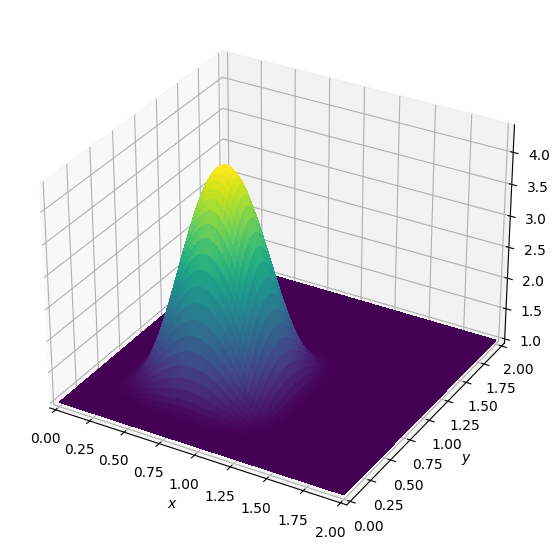

In [14]:
%matplotlib inline
from examples.cfd import init_smooth, plot_field

nt = 100  # Number of timesteps
dt = 0.2 * 2. / 80  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)

# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=u.data[1], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(u.data[0])

Next, we wish to discretise our governing equation so that a functional `Operator` can be created from it. We begin by simply writing out the equation as a symbolic expression, while using shorthand expressions for the derivatives provided by the `Function` object. This will create a symbolic object of the dicretised equation.

Using the Devito shorthand notation, we can express the governing equations as:

In [15]:
eq = Eq(u.dt + c * u.dxl + c * u.dyl)
eq

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), y) + Derivative(u(t, x, y), t), 0)

We now need to rearrange our equation so that the term $u(t+dt, x, y)$ is on the left-hand side, since it represents the next point in time for our state variable $u$. Devito provides a utility called `solve`, built on top of SymPy's `solve`, to rearrange our equation so that it represents a valid state update for $u$. Here, we use `solve` to create a valid stencil for our update to `u(t+dt, x, y)`:

In [16]:
stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)
update

Eq(u(t + dt, x, y), dt*(-u(t, x, y)/h_y + u(t, x, y - h_y)/h_y - u(t, x, y)/h_x + u(t, x - h_x, y)/h_x + u(t, x, y)/dt))

The right-hand side of the 'update' equation should be a stencil of the shape
<img src="figures/stencil_convection.png" style="width: 160px;"/>

Once we have created this 'update' expression, we can create a Devito `Operator`. This `Operator` will basically behave like a Python function that we can call to apply the created stencil over our associated data, as long as we provide all necessary unknowns. In this case we need to provide the number of timesteps to compute via the keyword `time` and the timestep size via `dt` (both have been defined above):

Operator `Kernel` ran in 0.01 s


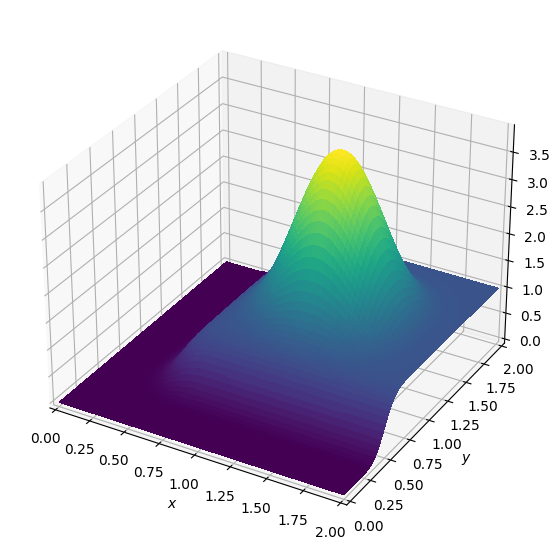

In [17]:
op = Operator(update)
op(time=nt+1, dt=dt)

plot_field(u.data[0])

Note that the real power of Devito is hidden within `Operator`, it will automatically generate and compile the optimized C code. We can look at this code (noting that this is not a requirement of executing it) via:

In [18]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;

  /* Flush denormal numbers to zero in hardware */
  

#### Second derivatives and high-order stencils

In the above example only a combination of first derivatives was present in the governing equation. However, second (or higher) order derivatives are often present in scientific problems of interest, notably any PDE modeling diffusion. To generate second order derivatives we must give the `devito.Function` object another piece of information: the desired discretisation of the stencil(s).

First, lets define a simple second derivative in `x`, for which we need to give $u$ a `space_order` of (at least) `2`. The shorthand for this second derivative is `u.dx2`.

In [19]:
u = TimeFunction(name='u', grid=grid, space_order=2)
u.dx2

Derivative(u(t, x, y), (x, 2))

In [20]:
u.dx2.evaluate

-2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2

We can increase the discretisation arbitrarily if we wish to specify higher order FD stencils:

In [21]:
u = TimeFunction(name='u', grid=grid, space_order=4)
u.dx2

Derivative(u(t, x, y), (x, 2))

In [22]:
u.dx2.evaluate

-2.5*u(t, x, y)/h_x**2 - 0.0833333333*u(t, x - 2*h_x, y)/h_x**2 + 1.33333333*u(t, x - h_x, y)/h_x**2 + 1.33333333*u(t, x + h_x, y)/h_x**2 - 0.0833333333*u(t, x + 2*h_x, y)/h_x**2

To implement the diffusion or wave equations, we must take the Laplacian $\nabla^2 u$, which is the sum of the second derivatives in all spatial dimensions. For this, Devito also provides a shorthand expression, which means we do not have to hard-code the problem dimension (2D or 3D) in the code. To change the problem dimension we can create another `Grid` object and use this to re-define our `Function`'s:

In [23]:
grid_3d = Grid(shape=(5, 6, 7), extent=(1., 1., 1.))

u = TimeFunction(name='u', grid=grid_3d, space_order=2)
u

u(t, x, y, z)

We can re-define our function `u` with a different `space_order` argument to change the discretisation order of the stencil expression created. For example, we can derive an expression of the 12th-order Laplacian $\nabla^2 u$:

In [24]:
u = TimeFunction(name='u', grid=grid_3d, space_order=12)
u.laplace

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

The same expression could also have been generated explicitly via:

In [25]:
u.dx2 + u.dy2 + u.dz2

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

#### Derivatives of composite expressions

Derivatives of any arbitrary expression can easily be generated:

In [26]:
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2, time_order=2)

In [27]:
(v.dt2 + u.laplace).dx2

Derivative(Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2)), (x, 2))

Which can, depending on the chosen discretisation, lead to fairly complex stencils:

In [28]:
(v.dt2 + u.laplace).dx2.evaluate

-2.0*(-2.0*u(t, x, y)/h_y**2 + u(t, x, y - h_y)/h_y**2 + u(t, x, y + h_y)/h_y**2 - 2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2 - 2.0*v(t, x, y)/dt**2 + v(t - dt, x, y)/dt**2 + v(t + dt, x, y)/dt**2)/h_x**2 + (-2.0*u(t, x - h_x, y)/h_y**2 + u(t, x - h_x, y - h_y)/h_y**2 + u(t, x - h_x, y + h_y)/h_y**2 + u(t, x, y)/h_x**2 + u(t, x - 2*h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_x**2 - 2.0*v(t, x - h_x, y)/dt**2 + v(t - dt, x - h_x, y)/dt**2 + v(t + dt, x - h_x, y)/dt**2)/h_x**2 + (-2.0*u(t, x + h_x, y)/h_y**2 + u(t, x + h_x, y - h_y)/h_y**2 + u(t, x + h_x, y + h_y)/h_y**2 + u(t, x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_x**2 + u(t, x + 2*h_x, y)/h_x**2 - 2.0*v(t, x + h_x, y)/dt**2 + v(t - dt, x + h_x, y)/dt**2 + v(t + dt, x + h_x, y)/dt**2)/h_x**2

**IMPORTANT**: Devito should not be thought of as a black box. Every aspect of the DSL has a well defined meaning (as we saw with the definition of derivatives etc. above). Although due to time-constraints there are some aspects of the DSL we're going to have to 'gloss' over, these are also rigorously (and clearly) defined and hence would not be difficult to explain if we had the time.

### The wave-equation

Now that we know the basics of the Devito DSL we're ready to start thinking about how to build our wave-propagator. In the remaining time today we'll write some code to solve the wave-equation and then next time we'll use these ideas to develop our FWI code.

The acoustic wave equation for the wavefield/pressure field $u(\mathbf{x},t)$ and the square slowness $m$, defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source $q$ is given by:

\begin{cases}
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) = q \ \text{in } \Omega \\
 &u(.,t=0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}

with the zero initial conditions to guarantee unicity of the solution.
The boundary conditions are Dirichlet conditions:
\begin{equation}
 u(\mathbf{x},t)|_{\delta\Omega} = 0
\end{equation}

where $\delta\Omega$ is the surface of the boundary of the model $\Omega$.

The core process we are aiming to model is a seismic survey, which consists of two main components:

- **Source** - A source is positioned at a single or a few physical locations where artificial pressure is injected into the domain we want to model. In the case of land survey, it is usually dynamite blowing up at a given location, or a vibroseis (a vibrating engine generating continuous sound waves). For a marine survey, the source is an air gun sending a bubble of compressed air into the water that will expand and generate a seismic wave.
- **Receiver** - A set of microphones or hydrophones are used to measure the resulting wave and create a set of measurements called a *Shot Record*. These measurements are recorded at multiple locations, and usually at the surface of the domain or at the bottom of the ocean in some marine cases.

In order to create a numerical model of a seismic survey, we need to solve the wave equation and implement source and receiver interpolation to inject the source and record the seismic wave at sparse point locations in the grid.


<img src='./figures/survey-ship-diagram.png' width=400>


### Finite domains

The last piece of the puzzle is the computational limitation. In the field, the seismic wave propagates in every direction to an "infinite" distance. However, solving the wave equation in a mathematically/discrete infinite domain is not feasible. In order to compensate, Absorbing Boundary Conditions (ABC) or Perfectly Matched Layers (PML) are required to mimic an infinite domain. These two methods allow us to approximate an unbounded media by damping and absorbing the waves at the limit of the domain to avoid reflections.

The simplest of these methods is the absorbing damping mask. The core idea is to extend the physical domain and to add a *sponge mask* in this extension that will absorb the incident waves. The acoustic wave equation with this damping mask can be rewritten as:

\begin{cases} 
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) + \eta \frac{\partial u(\mathbf{x},t)}{\partial t}=q  \ \text{in } \Omega \\
 &u(.,0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}

where $\eta$ is the damping mask which is equal to $0$ inside the physical domain and increasing inside the sponge layer. Multiple choice of profile can be chosen for $\eta$ from, e.g., linear to exponential.

#### Define the physical problem

The first step is to define the physical model:

- What are the physical dimensions of interest
- What is the velocity profile of this physical domain

We will create a simple velocity model here by hand for demonstration purposes. This model essentially consists of two layers, each with a different velocity: $1.5km/s$ in the top layer and $2.5km/s$ in the bottom layer. We will use this simple model a lot in the following tutorials, so we will rely on a utility function to create it again later.

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


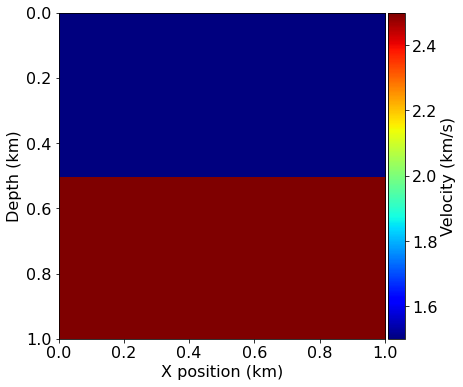

In [29]:
#NBVAL_IGNORE_OUTPUT
import numpy as np
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

#### Acquisition geometry

To fully define our problem setup we also need to define the source that injects the wave to the model and the set of receiver locations at which to the wavefield is sampled. The source time signature will be modelled using a 'Ricker' wavelet whose form is defined as

\begin{equation}
  q(t) = \left(1-2\pi^2 f_0^2 \left(t - \frac{1}{f_0}\right)^2 \right)e^{- \pi^2 f_0^2 (t - f_0^{-1})}.
\end{equation}

To include such a source signature in our model we first need to define the time duration of our model and the timestep size, which is dictated by the CFL condition and our grid spacing. Luckily, our `Model` utility provides us with the critical timestep size, so we can fully discretize our model time axis as an array:

In [30]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

Recall that we can view the documentation for the `TimeAxis` object (or any other object via):

In [31]:
print(time_range.__doc__)


    Data object to store the TimeAxis. Exactly three of the four key arguments
    must be prescribed. Because of remainder values it is not possible to create
    a TimeAxis that exactly adhears to the inputs therefore start, stop, step
    and num values should be taken from the TimeAxis object rather than relying
    upon the input values.

    The four possible cases are:
    start is None: start = step*(1 - num) + stop
    step is None: step = (stop - start)/(num - 1)
    num is None: num = ceil((stop - start + step)/step);
                 because of remainder stop = step*(num - 1) + start
    stop is None: stop = step*(num - 1) + start

    Parameters
    ----------
    start : float, optional
        Start of time axis.
    step : float, optional
        Time interval.
    num : int, optional
        Number of values (Note: this is the number of intervals + 1).
        Stop value is reset to correct for remainder.
    stop : float, optional
        End time.
    


(Note: Values of the time steps are stored in `time_range.time_values`.)

We position the source at a depth of $20m$ and in the center of the $x$ axis ($\mathbf{x}_{src}=(500m, 20m)$), with a peak wavelet frequency of $10Hz$.

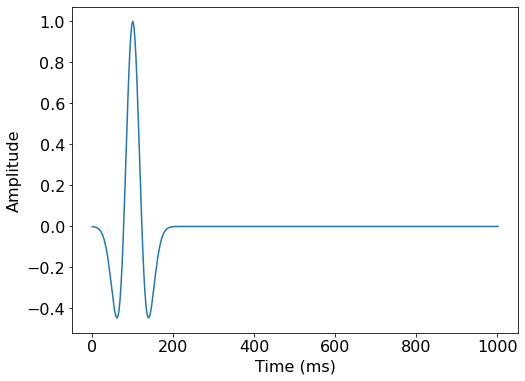

In [32]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Set source coordinates
src.coordinates.data[0, 0] = np.array(model.domain_size[0]) * .5
src.coordinates.data[0, 1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet via:
src.show()

Similarly to our source object, we can now define our receiver geometry as a symbol of type `Receiver`. It is worth noting here that both utility classes, `RickerSource` and `Receiver` are thin wrappers around Devito's `SparseTimeFunction` type, which encapsulates sparse point data and allows us to inject and interpolate values into and out of the computational grid. As we have already seen, both types provide a `.coordinates` property to define the position within the domain of all points encapsulated by that symbol. 

In this example we will position receivers at the same depth as the source, every $10m$ along the x axis. The `rec.data` property will be initialized, but left empty, as we will compute the receiver readings during the simulation.

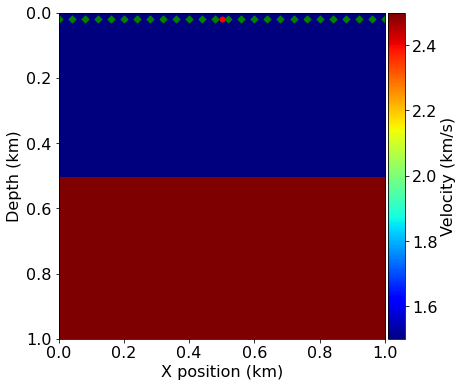

In [33]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

### Finite-difference discretization

The finite-difference approximation is derived from Taylor expansions of the continuous field after removing the error term.

#### Time discretization

We only consider the second order time discretization for now. From the Taylor expansion, the second order discrete approximation of the second order time derivative is:
\begin{equation}
\begin{aligned}
 \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} = \frac{\mathbf{u}(\mathbf{x},\mathbf{t+\Delta t}) - 2 \mathbf{u}(\mathbf{x},\mathbf{t}) + \mathbf{u}(\mathbf{x},\mathbf{t-\Delta t})}{\mathbf{\Delta t}^2} + O(\mathbf{\Delta t}^2).
\end{aligned}
\end{equation} 

where $\mathbf{u}$ is the discrete wavefield, $\mathbf{\Delta t}$ is the discrete
time-step (distance between two consecutive discrete time points) and $O(\mathbf{\Delta
  t}^2)$ is the temporal discretization error term. The discretized approximation of the
second order time derivative is then given by dropping the error term. This derivative is represented in Devito by `u.dt2` where u is a `TimeFunction` object.

#### Spatial discretization 

We define the discrete Laplacian as the sum of the second order spatial
derivatives in the three dimensions:
\begin{equation}
\begin{aligned}
\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t})= \sum_{j=1}^{j=\frac{k}{2}} \Bigg[\alpha_j \Bigg(&
\mathbf{u}(\mathbf{x+jdx},\mathbf{y},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x-jdx},\mathbf{y},\mathbf{z},\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y+jdy},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y-jdy},\mathbf{z}\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z+jdz},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z-jdz},\mathbf{t})\Bigg) \Bigg] + \\
&3\alpha_0 \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}).
\end{aligned}
\end{equation}

where $\alpha_j$ are the appropriate finite difference weights for the approximation. This derivative is represented in Devito by `u.laplace`.

### Discretized Wave equation

With the space and time discretization defined, we can fully discretize the wave-equation with the combination of time and space discretizations and obtain the following second order in time and $k^{th}$ order in space discrete stencil to update one grid point at position $\mathbf{x}, \mathbf{y},\mathbf{z}$ at time $\mathbf{t}$, i.e.
\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

In [34]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [35]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

### Source injection and receiver interpolation

With a numerical scheme to solve the homogenous wave equation, we need to add the source to introduce seismic waves and to implement the measurement operator, and interpolation operator. This operation is linked to the discrete scheme and needs to be done at the proper time step. The semi-discretized in time wave equation with a source reads:

\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

It shows that in order to update $\mathbf{u}$ to the time $\mathbf{t+\Delta t}$ we must inject the value of the source term $\mathbf{q}$ at time $\mathbf{t}$. In Devito, this corresponds to the update of $u$ at index $t+1$ (t = time implicitly) with the source of time $t$.

In [36]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

### Devito operator and solve

After constructing all the necessary expressions for updating the wavefield, injecting the source term and interpolating onto the receiver points, we can now create the Devito operator that will generate the C code at runtime. When creating the operator, Devito's two optimization engines will log which performance optimizations have been performed:
* **DSE:** The Devito Symbolics Engine will attempt to reduce the number of operations required by the kernel.
* **DLE:** The Devito Loop Engine will perform various loop-level optimizations to improve runtime performance.

**Note**: The argument `subs=model.spacing_map` causes the operator to substitute values for our current grid spacing into the expressions before code generation. This reduces the number of floating point operations executed by the kernel by pre-evaluating certain coefficients.

In [37]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

Now we can execute the create operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [38]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0032330000000000223, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1.4000000000000003e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00045600000000000393, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

After running our operator kernel, the data associated with the receiver symbol `rec.data` has now been populated due to the interpolation expression we inserted into the operator. This allows us the visualize the shot record:

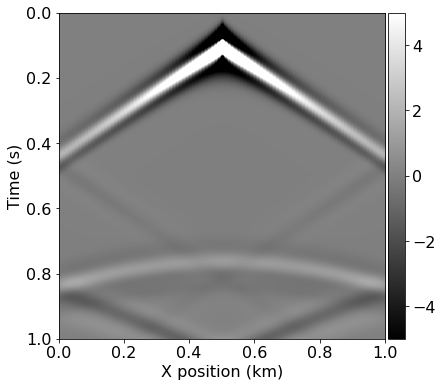

In [39]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

And our propagator is now ready to plug into an FWI framework!

## Excersie: Comparison against exact solution

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="figures/exact_solution.png" width="450" height="450" align="center"/>

It can be shown that the analytical solution to this problem is:
\begin{equation}
 u(x,t)=\sum_{n=1}^{\infty}A_{n}\sin\left(\frac{n\pi x}{10}\right)\cos\left(\frac{n\pi ct}{10}\right),
\end{equation}
where
\begin{equation}
  A_n=\frac{2}{n\pi}\left[\cos\left(\frac{4n\pi}{10}\right)-\cos\left(\frac{6n\pi}{10}\right)\right].
\end{equation}

Below is a snippet of code to plot the exact result at any point in time. You can use it to explore the evolution of the wave:

In [40]:
from numpy import sin, cos, pi, linspace, shape, zeros, mod

import matplotlib.pyplot as plt

# Global constants
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound

x = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Calculate exact solution

def u_e(x, t):
    s = zeros(x.size)
    for i in range(1,N+1):
        s+=A_n(i)*sin(i*pi*x/L)*cos(i*pi*c*t/L)
    return s

def A_n(n):
    const = 2/n/pi*(cos(4*n*pi/L)-cos(6*n*pi/L))
    return const

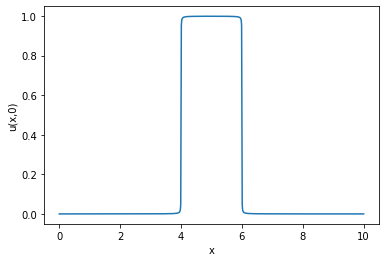

In [41]:
%matplotlib inline
# Plot solution at a point T in time
T = 0
plt.plot(x, u_e(x, T))
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

How would you write a Devito code to compute the evolution in time of the wave?

In [42]:
# Some hints:

# Required imports
from devito import Grid, TimeFunction, Eq, solve, Operator

# Define the grid/computational domain
grid = Grid(shape=(l), extent=(L))
t_s = grid.stepping_dim

# Wavefield
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)

dx = abs(x[1]-x[0])
# Critical time-step
dt = 0.004 # (dt < 0.42*dx/c)

# Set the initial conditions
u0 = u_e(x, 0)
u1 = u_e(x, dt)
u.data[0,:] = u0
u.data[1,:] = u1

# Boundary conditions can be defined by additional equations:
bc = [Eq(u[t_s+1, 0], 0)]
bc += [Eq(u[t_s+1, -1], 0)]

# Note -- Boundary conditions can be added to an operator as follows:
# op = Operator([eq]+bc)

A worked solution will be posted prior to the next lecture.